Status: in progress

Remark: All the analysis is going to be aggregating all the data by hour, so doing it in that way, we can analyse all the years together and compare them

Extra information about VLT platform: https://www.eso.org/public/images/vlt-jfs_4850/

In [115]:
# packages 
import pandas as pd
import numpy as np

import missingno as msno 

from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_theme(style="ticks")

import sys
sys.path.append('/Users/ben_rss/Documents/CMM_2024/cmmProject/')


In [2]:
## connecting
db_name = "meteo_paranal" # meteo_paranal_test, meteo_paranal

client = MongoClient("mongodb://localhost:27017/")
db = client[db_name] # meteo_paranal_test
collection = db[db_name]

## Counting Samples

In [3]:
print('Expected samples per year: ', 60*24*365) # asuming that we have un sample per minute

Expected samples per year:  525600


In [4]:
## samples per year
pipeline = [
    {   # it extracts the year from Date time
        "$project": { "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},}
    },
    { "$group": {# grouping by year and sum per sample 
            "_id": "$year",
            "count": {"$sum": 1}}
    },
    {"$sort": {"_id": 1}  # sort by year in ascending order
    }
]
result = list(collection.aggregate(pipeline))
for result_it in result:
    print(f"Year: {result_it['_id']}, Count: {result_it['count']}")

Year: 1998, Count: 369592
Year: 1999, Count: 506326
Year: 2000, Count: 518674
Year: 2001, Count: 508279
Year: 2002, Count: 512708
Year: 2003, Count: 514058
Year: 2004, Count: 517821
Year: 2005, Count: 514404
Year: 2006, Count: 516553
Year: 2007, Count: 496584
Year: 2008, Count: 497955
Year: 2009, Count: 456568
Year: 2010, Count: 447881
Year: 2011, Count: 505192
Year: 2012, Count: 508719
Year: 2013, Count: 493728
Year: 2014, Count: 422677
Year: 2015, Count: 417335
Year: 2016, Count: 519882
Year: 2017, Count: 520632
Year: 2018, Count: 523335
Year: 2019, Count: 524947
Year: 2020, Count: 526351
Year: 2021, Count: 524075
Year: 2022, Count: 524246
Year: 2023, Count: 525538
Year: 2024, Count: 23200


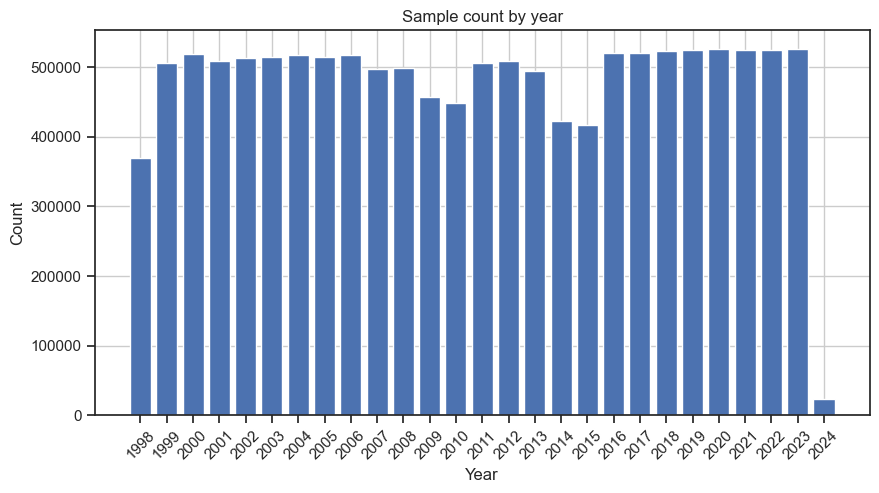

In [5]:
years = [result_it['_id'] for result_it in result]
counts = [result_it['count'] for result_it in result]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(years, counts)
plt.xticks(years,rotation=45)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sample count by year')
plt.grid(True)
plt.show()

In [27]:
from utils.utils_columns import numeric_cols_paranal
numeric_cols_paranal # columns using

['Air Pressure at ground [hPa]',
 'Air Pressure Normalised [hPa]',
 'Air Temperature at 30m [C]',
 'Air Temperature at 2m [C]',
 'Air Temperature at ground [C]',
 'Air Temperature below VLT [C]',
 'Dew Temperature at 30m [C]',
 'Dew Temperature at 2m [C]',
 'Dew Temperature below VLT [C]',
 'Rain intensity below VLT [%]',
 'Relative Humidity at 30m [%]',
 'Relative Humidity at 2m [%]',
 'Relative Humidity below VLT [%]',
 'Wind Direction at 30m (0/360) [deg]',
 'Wind Direction at 30m (180/-180) [deg]',
 'Wind Direction at 10m (0/360) [deg]',
 'Wind Direction at 10m (180/-180) [deg]',
 'Wind Speed at 30m [m/s]',
 'Wind Speed at 10m [m/s]',
 'Wind Speed U at 20m [m/s]',
 'Wind Speed V at 20m [m/s]',
 'Wind Speed W at 20m [m/s]',
 'Air Pressure instantanous [hPa]',
 'Air Temperature instantanous at 30m [C]',
 'Air Temperature instantanous at 2m [C]',
 'Air Temperature instantanous at ground [C]',
 'Air Temperature instantaneous below VLT [C]',
 'Dew Temperature istantaneous at 30m [C]',
 

In [26]:
## utils functions (skip this cell)

def dict_to_datetime(x):
   return f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"


def get_datetime_index(df):
    df['_id'] = pd.to_datetime(df['_id'].apply(dict_to_datetime))
    df = df.set_index(['_id'])
    df = df.sort_index(ascending=True)
    return df

def get_df(aggregated_expression):

    pipeline = [
        {"$group": {
                "_id": {
                    "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},
                    "month": {"$month": {"$dateFromString": {"dateString": "$Date time"}}},
                    "day": {"$dayOfMonth": {"$dateFromString": {"dateString": "$Date time"}}},
                    "hour": {"$hour": {"$dateFromString": {"dateString": "$Date time"}}},
                }, 
                **aggregated_expression}},
        {"$sort": {"_id.year": 1, "_id.month": 1, "_id.day": 1, "_id.hour": 1} }
    ]

    result = list(collection.aggregate(pipeline))

    return pd.DataFrame(result)



Remark: that pipeline calculate the average per period only in the numeric values. Nan values are not considered:
https://www.mongodb.com/docs/manual/reference/operator/aggregation/avg/

In [7]:
## uploading data

# defining what we want
mean_agg = {f: {"$avg": f"${f}"} for f in numeric_col}
std_agg = {f: {"$stdDevSamp": f"${f}"} for f in numeric_col}
# min_agg = {f: {"$min": f"${f}"} for f in numeric_col}
# max_agg = {f: {"$max": f"${f}"} for f in numeric_col}

# getting df
df_mean = get_df(mean_agg)
df_std = get_df(std_agg)
# df_min = get_df(min_agg)
# df_max = get_df(max_agg)

# getting datetime index
df_mean = get_datetime_index(df_mean)
df_std = get_datetime_index(df_std)
# df_min = get_datetime_index(df_min)
# df_max = get_datetime_index(df_max)


In [40]:
df=df_mean.copy() # just for save
print('DF shape: ',df.shape)
display(df.head(3))

DF shape:  (218645, 49)


Air Pressure at ground [hPa]  \
_id                                                 
1998-07-19 18:00:00                    743.227800   
1998-07-19 19:00:00                    742.884000   
1998-07-19 20:00:00                    743.166333   

                     Air Pressure Normalised [hPa]  \
_id                                                  
1998-07-19 18:00:00                    1025.033800   
1998-07-19 19:00:00                    1024.588333   
1998-07-19 20:00:00                    1024.955333   

                     Air Temperature at 30m [C]  Air Temperature at 2m [C]  \
_id                                                                          
1998-07-19 18:00:00                     11.8068                  12.630600   
1998-07-19 19:00:00                     11.4845                  12.151167   
1998-07-19 20:00:00                     11.2140                  11.778667   

                     Air Temperature at ground [C]  \
_id                                                  
1998-07-19 18:00:00                      15.082000   
1998-07-19 19:00:00                      15.479833   
1998-07-19 20:00:00                      15.683000   

                     Air Temperature below VLT [C]  \
_id                                                  
1998-07-19 18:00:00                            NaN   
1998-07-19 19:00:00                            NaN   
1998-07-19 20:00:00                            NaN   

                     Dew Temperature at 30m [C]  Dew Temperature at 2m [C]  \
_id                                                                          
1998-07-19 18:00:00                  -11.900000                 -11.934600   
1998-07-19 19:00:00                  -11.908000                 -12.398667   
1998-07-19 20:00:00                  -12.614167                 -12.911500   

                     Dew Temperature below VLT [C]  \
_id                                                  
1998-07-19 18:00:00                            NaN   
1998-07-19 19:00:00                            NaN   
1998-07-19 20:00:00                            NaN   

                     Rain intensity below VLT [%]  ...  \
_id                                                ...   
1998-07-19 18:00:00                           NaN  ...   
1998-07-19 19:00:00                           NaN  ...   
1998-07-19 20:00:00                           NaN  ...   

                     Wind Speed V instantanous at 20m [m/s]  \
_id                                                           
1998-07-19 18:00:00                                     NaN   
1998-07-19 19:00:00                                     NaN   
1998-07-19 20:00:00                                     NaN   

                     Wind Speed W instantanous at 20m [m/s]  \
_id                                                           
1998-07-19 18:00:00                                     NaN   
1998-07-19 19:00:00                                     NaN   
1998-07-19 20:00:00                                     NaN   

                     Particle (Large) at 20m [1/m^3]  \
_id                                                    
1998-07-19 18:00:00                       436.860000   
1998-07-19 19:00:00                       352.816667   
1998-07-19 20:00:00                       494.283333   

                     Particle (Large) at 10m [1/m^3]  \
_id                                                    
1998-07-19 18:00:00                       213.840000   
1998-07-19 19:00:00                       209.400000   
1998-07-19 20:00:00                       199.633333   

                     Particle (Small) at 20m [1/m^3]  \
_id                                                    
1998-07-19 18:00:00                     22346.740000   
1998-07-19 19:00:00                     17865.550000   
1998-07-19 20:00:00                     20182.683333   

                     Particle (Small) at 10m [1/m^3]  \
_id                                                    
1998-07-19 

In [247]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146219 entries, 2006-12-31 13:00:00 to 2024-01-17 02:00:00
Data columns (total 42 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Air Pressure at ground [hPa]                 146193 non-null  float64
 1   Air Pressure Normalised [hPa]                145828 non-null  float64
 2   Air Temperature at 30m [C]                   146208 non-null  float64
 3   Air Temperature at 2m [C]                    146209 non-null  float64
 4   Air Temperature at ground [C]                145830 non-null  float64
 5   Air Temperature below VLT [C]                145829 non-null  float64
 6   Dew Temperature at 30m [C]                   144214 non-null  float64
 7   Dew Temperature at 2m [C]                    145067 non-null  float64
 8   Dew Temperature below VLT [C]                145712 non-null  float64
 9   Rain intensity below VLT 

<Figure size 640x480 with 0 Axes>

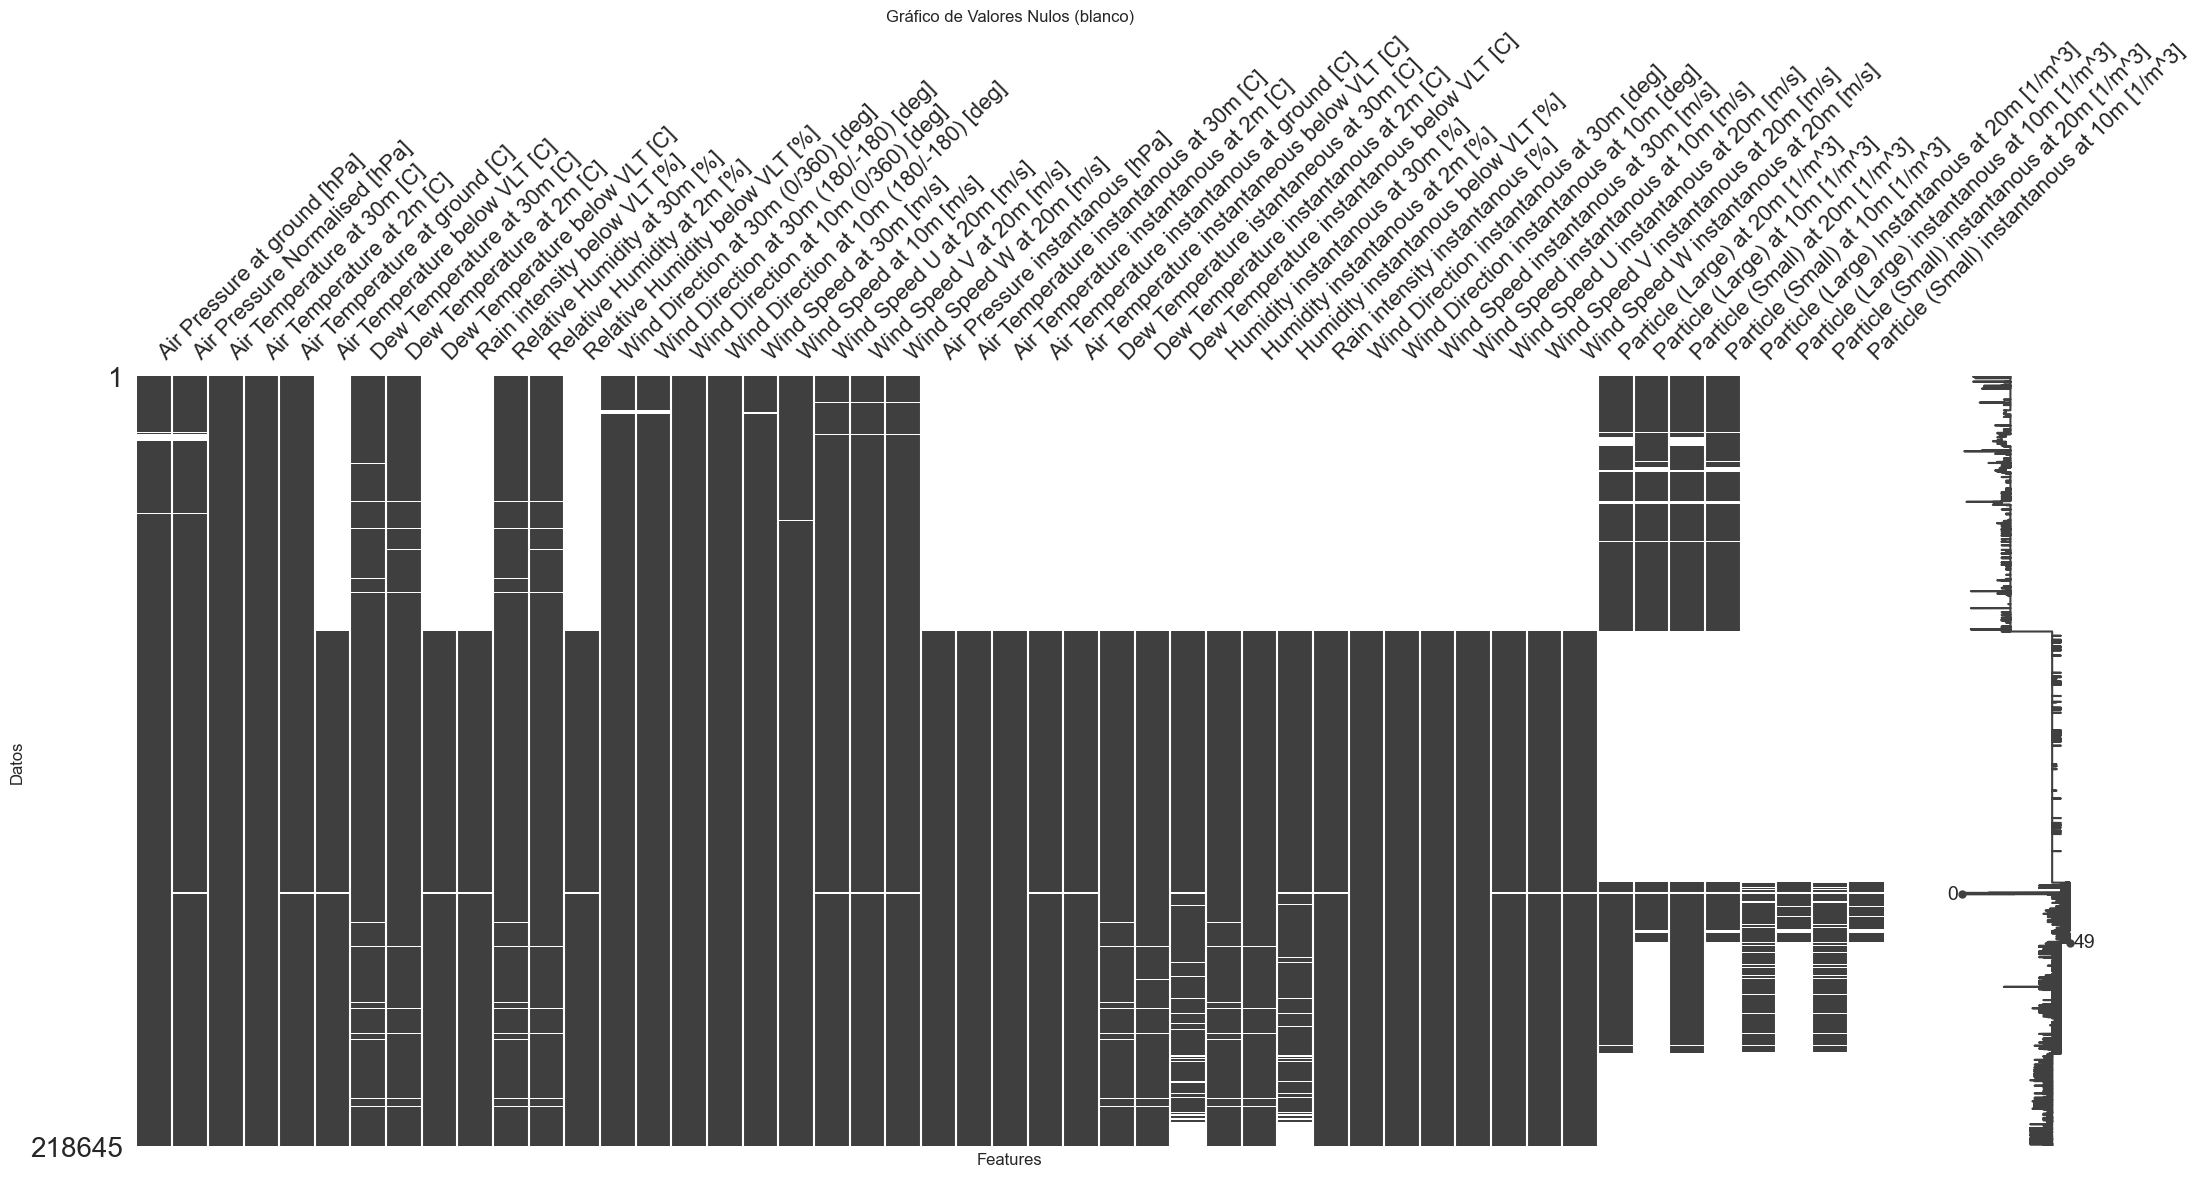

In [43]:
## general values of nan values
plt.clf()
msno.matrix(df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
# plt.gcf().set_size_inches(30, 25)
# plt.savefig("../plots/nullplot.png",dpi = 100)
plt.show()

In [11]:
## These are variables with mostly nan values
nan_columns =   [ 
   'Particle (Large) at 20m [1/m^3]',
   'Particle (Large) at 10m [1/m^3]',
   'Particle (Small) at 20m [1/m^3]',
   'Particle (Small) at 10m [1/m^3]',
   'Particle (Large) Instantanous at 20m [1/m^3]',
   'Particle (Large) instantanous at 10m [1/m^3]',
   'Particle (Small) instantanous at 20m [1/m^3]',
   'Particle (Small) instantanous at 10m [1/m^3]',]

<Figure size 640x480 with 0 Axes>

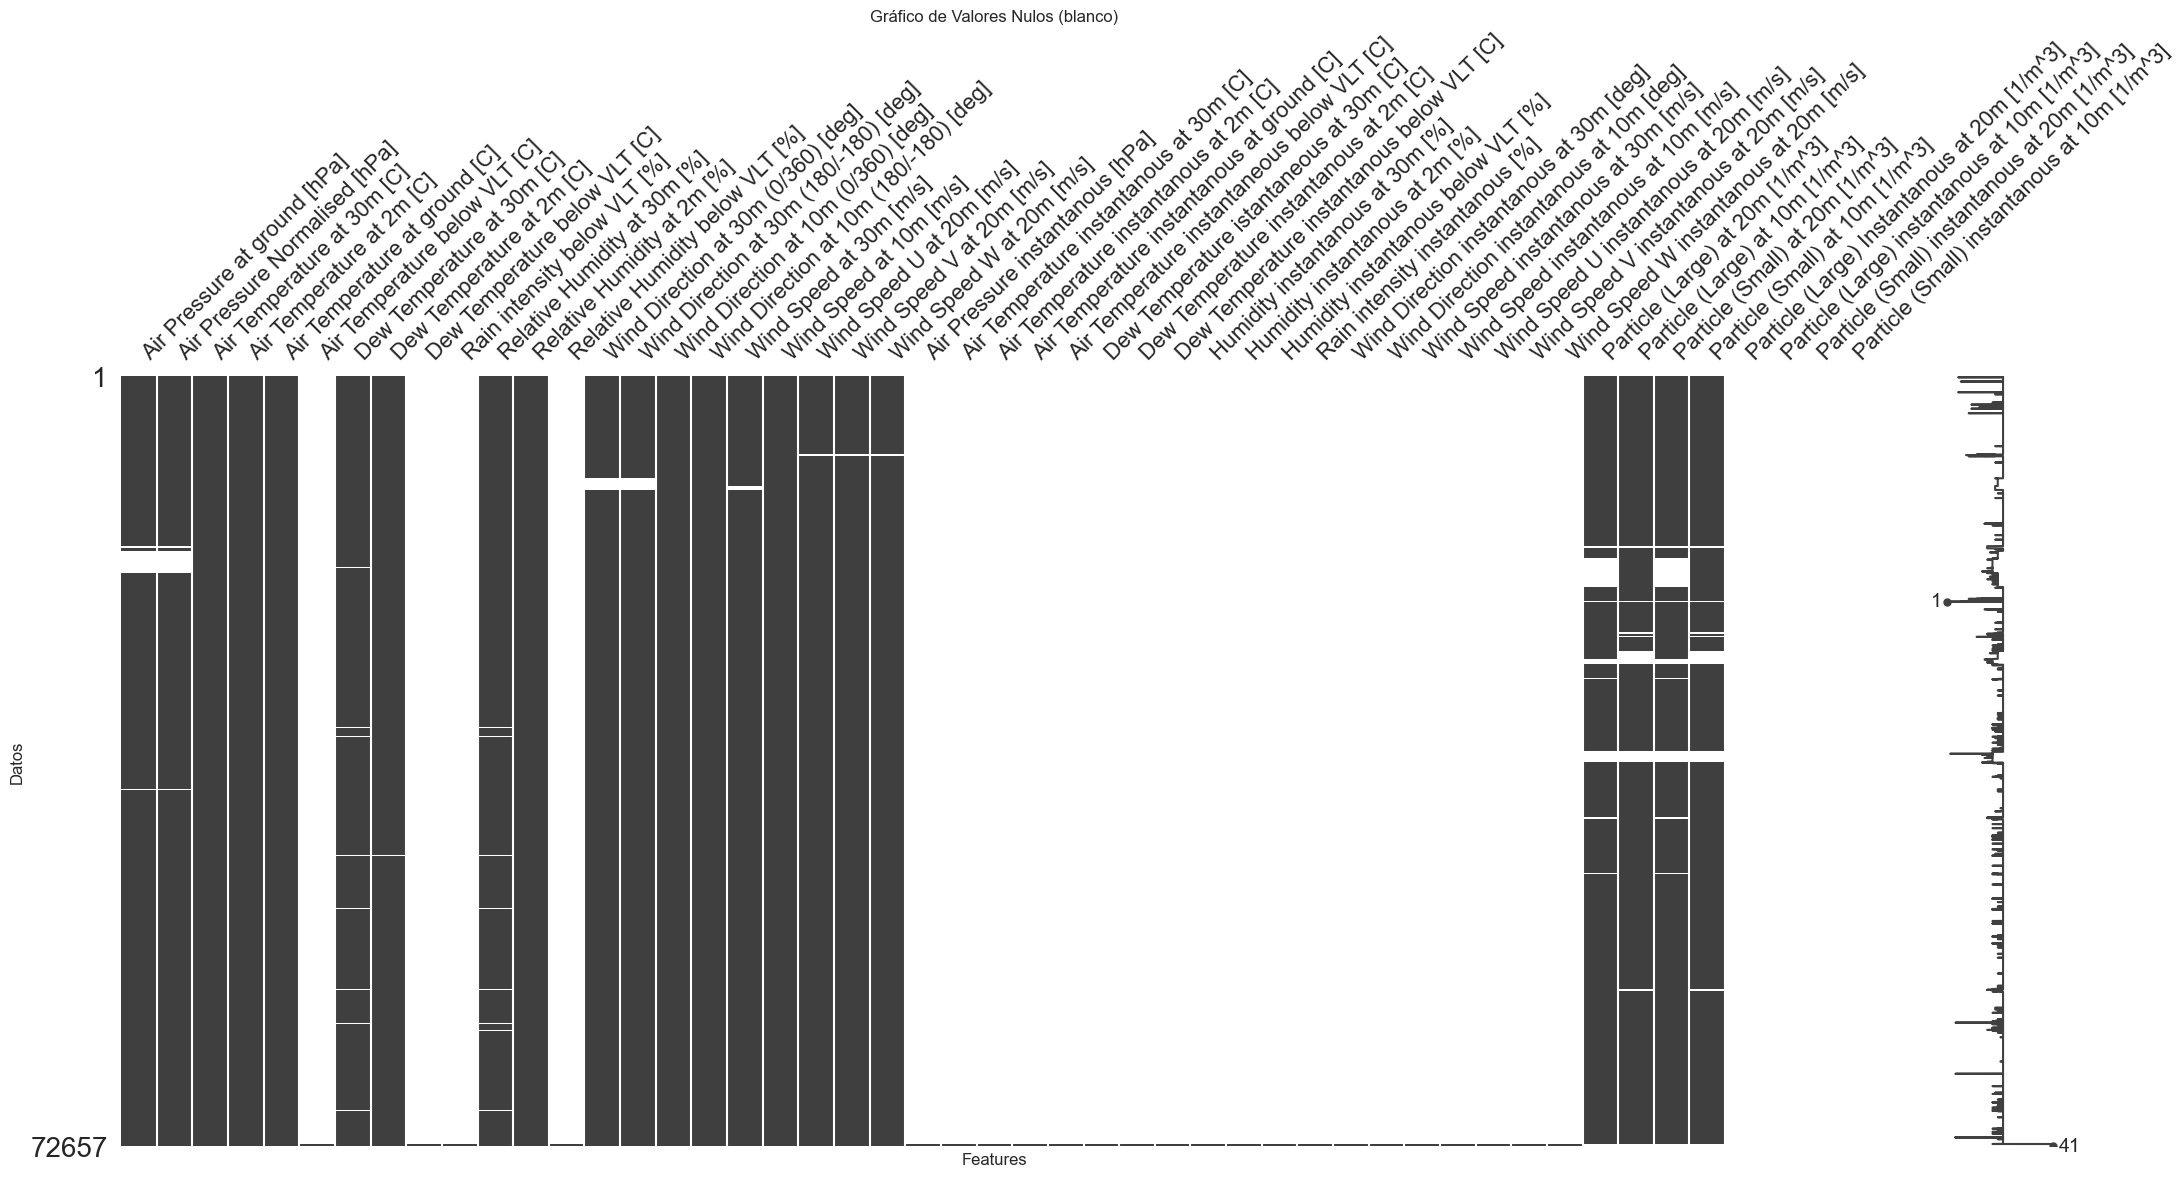

In [44]:
# plotting by dates
date_i = None
date_f =  '2007-01-10 12:00:00' #'2020-08-25 12:00:00'
plt.clf()
msno.matrix(df.loc[date_i:date_f])
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
# plt.savefig("../plots/nullsplot_date.png",dpi = 100)
plt.show()

In [13]:
# some variables where it started to appear null values
extra_cols = ['Air Pressure instantanous [hPa]',
 'Air Temperature instantanous at 30m [C]',
 'Air Temperature instantanous at 2m [C]',
 'Air Temperature instantanous at ground [C]',
 'Air Temperature instantaneous below VLT [C]',
 'Dew Temperature istantaneous at 30m [C]',
 'Dew Temperature instantanous at 2m [C]',]

In [14]:
## How it is looks nan values in extra_cols
df.loc['2006-12-31 10:00:00':'2006-12-31 14:00:00',extra_cols]
### 2006-12-31 12:00:00

Air Pressure instantanous [hPa]  \
_id                                                    
2006-12-31 10:00:00                              NaN   
2006-12-31 11:00:00                              NaN   
2006-12-31 12:00:00                              NaN   
2006-12-31 13:00:00                       744.418333   
2006-12-31 14:00:00                       744.453333   

                     Air Temperature instantanous at 30m [C]  \
_id                                                            
2006-12-31 10:00:00                                      NaN   
2006-12-31 11:00:00                                      NaN   
2006-12-31 12:00:00                                      NaN   
2006-12-31 13:00:00                                16.850833   
2006-12-31 14:00:00                                17.144667   

                     Air Temperature instantanous at 2m [C]  \
_id                                                           
2006-12-31 10:00:00                                     NaN   
2006-12-31 11:00:00                                     NaN   
2006-12-31 12:00:00                                     NaN   
2006-12-31 13:00:00                               17.338333   
2006-12-31 14:00:00                               17.774833   

                     Air Temperature instantanous at ground [C]  \
_id                                                               
2006-12-31 10:00:00                                         NaN   
2006-12-31 11:00:00                                         NaN   
2006-12-31 12:00:00                                         NaN   
2006-12-31 13:00:00                                   19.563167   
2006-12-31 14:00:00                                   19.443667   

                     Air Temperature instantaneous below VLT [C]  \
_id                                                                
2006-12-31 10:00:00                                          NaN   
2006-12-31 11:00:00                                          NaN   
2006-12-31 12:00:00                                          NaN   
2006-12-31 13:00:00                                    18.654500   
2006-12-31 14:00:00                                    19.147667   

                     Dew Temperature istantaneous at 30m [C]  \
_id                                                            
2006-12-31 10:00:00                                      NaN   
2006-12-31 11:00:00                                      NaN   
2006-12-31 12:00:00                                      NaN   
2006-12-31 13:00:00                                -6.141667   
2006-12-31 14:00:00                                -5.721667   

                     Dew Temperature instantanous at 2m [C]  
_id                                                          
2006-12-31 10:00:00                                     NaN  
2006-12-31 11:00:00                                     NaN  
2006-12-31 12:00:00                                     NaN  
2006-12-31 13:00:00                               -6.199500  
2006-12-31 14:00:00                               -5.789333

* <= 2006-12-31 12:00:00 there is no data for some columns, these are for example in the variable "extra_cols".
Also if you check paranal samples in the endpoint, you can see there is nothing before to the corresponding variants of those columns. You can check these dates "2006-12-31..2007-01-01" selecting all fields. http://archive.eso.org/wdb/wdb/asm/meteo_paranal/form


In [48]:
# dropping what we won't use
df=df_mean.copy()
df = df.loc['2006-12-31 13:00:00':]
df = df.drop(columns=nan_columns,axis=1)
numeric_col = list(df.columns)

## Correlations

In [246]:
## correlation function
def get_principal_correlations(df_corr,n_display):

    upper_triangle_correlation = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    top_positive_correlations = upper_triangle_correlation.unstack().sort_values(ascending=False)[:n_display]
    top_negative_correlations = upper_triangle_correlation.unstack().sort_values(ascending=True)[:n_display]

    rename_columns={'level_0':'feature1','level_1':'feature2',0:'Correlation'}

    less_correlated = upper_triangle_correlation.unstack().reset_index()
    less_correlated.rename(columns=rename_columns,inplace=True)
    less_correlated.Correlation=less_correlated.Correlation.apply(lambda x : abs(x))
    less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]

    top_positive_correlations=top_positive_correlations.reset_index()
    top_positive_correlations.rename(columns=rename_columns,inplace=True)

    top_negative_correlations=top_negative_correlations.reset_index()
    top_negative_correlations.rename(columns=rename_columns,inplace=True)


    return top_negative_correlations,top_positive_correlations,less_correlated

In [34]:
## getting principal correlations in excel format, located in corraltions/
top_negative_correlations,top_positive_correlations,less_correlated = get_principal_correlations(df.corr(),n_display=150)

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_25436/678062977.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]


In [245]:
# display(top_negative_correlations)
# display(top_positive_correlations)
# display(less_correlated)
with pd.option_context('display.max_rows', None,):
    print('top negative correlations')
    display(top_negative_correlations.loc[0:20])
    print('top positive correlations')
    display(top_positive_correlations.loc[50:80])
    # display(less_correlated)

top negative correlations


feature1  \
0                  Wind Speed W at 20m [m/s]   
1     Wind Speed U instantanous at 20m [m/s]   
2     Wind Speed W instantanous at 20m [m/s]   
3     Wind Speed W instantanous at 20m [m/s]   
4                  Wind Speed V at 20m [m/s]   
5     Wind Speed V instantanous at 20m [m/s]   
6   Wind Direction instantanous at 10m [deg]   
7     Wind Speed V instantanous at 20m [m/s]   
8   Wind Direction instantanous at 30m [deg]   
9                  Wind Speed V at 20m [m/s]   
10    Wind Speed V instantanous at 20m [m/s]   
11    Wind Speed V instantanous at 20m [m/s]   
12  Wind Direction instantanous at 10m [deg]   
13    Wind Direction at 10m (180/-180) [deg]   
14  Wind Direction instantanous at 30m [deg]   
15                 Wind Speed U at 20m [m/s]   
16    Wind Direction at 10m (180/-180) [deg]   
17      Wind Speed instantanous at 10m [m/s]   
18    Wind Speed U instantanous at 20m [m/s]   
19    Wind Speed U instantanous at 20m [m/s]   
20                 Wind Speed V at 20m [m/s]   

                                    feature2  Correlation  
0                  Wind Speed U at 20m [m/s]    -0.790362  
1                  Wind Speed W at 20m [m/s]    -0.785736  
2     Wind Speed U instantanous at 20m [m/s]    -0.774999  
3                  Wind Speed U at 20m [m/s]    -0.766227  
4        Wind Direction at 30m (0/360) [deg]    -0.621473  
5        Wind Direction at 30m (0/360) [deg]    -0.617305  
6                  Wind Speed V at 20m [m/s]    -0.606710  
7   Wind Direction instantanous at 10m [deg]    -0.602892  
8                  Wind Speed V at 20m [m/s]    -0.593842  
9        Wind Direction at 10m (0/360) [deg]    -0.593569  
10  Wind Direction instantanous at 30m [deg]    -0.589972  
11       Wind Direction at 10m (0/360) [deg]    -0.589657  
12    Wind Direction at 10m (180/-180) [deg]    -0.569984  
13       Wind Direction at 10m (0/360) [deg]    -0.565485  
14    Wind Direction at 10m (180/-180) [deg]    -0.556472  
15                   Wind Speed at 10m [m/s]    -0.550935  
16       Wind Direction at 30m (0/360) [deg]    -0.550881  
17                 Wind Speed U at 20m [m/s]    -0.550361  
18                   Wind Speed at 10m [m/s]    -0.549896  
19      Wind Speed instantanous at 10m [m/s]    -0.549493  
20             Air Temperature below VLT [C]    -0.519579

top positive correlations


feature1  \
50     Wind Direction instantanous at 10m [deg]   
51          Wind Direction at 10m (0/360) [deg]   
52      Air Temperature instantanous at 30m [C]   
53                    Air Temperature at 2m [C]   
54       Air Temperature instantanous at 2m [C]   
55       Air Temperature instantanous at 2m [C]   
56       Wind Speed W instantanous at 20m [m/s]   
57                      Wind Speed at 10m [m/s]   
58         Wind Speed instantanous at 30m [m/s]   
59         Wind Speed instantanous at 10m [m/s]   
60         Wind Speed instantanous at 10m [m/s]   
61                Air Temperature below VLT [C]   
62      Air Temperature instantanous at 30m [C]   
63  Air Temperature instantaneous below VLT [C]   
64  Air Temperature instantaneous below VLT [C]   
65       Wind Direction at 10m (180/-180) [deg]   
66             Humidity instantanous at 30m [%]   
67      Dew Temperature istantaneous at 30m [C]   
68             Humidity instantanous at 30m [%]   
69                 Relative Humidity at 30m [%]   
70       Dew Temperature instantanous at 2m [C]   
71             Humidity instantanous at 30m [%]   
72                 Relative Humidity at 30m [%]   
73             Humidity instantanous at 30m [%]   
74             Humidity instantanous at 30m [%]   
75                 Relative Humidity at 30m [%]   
76              Humidity instantanous at 2m [%]   
77       Dew Temperature instantanous at 2m [C]   
78              Humidity instantanous at 2m [%]   
79                  Relative Humidity at 2m [%]   
80             Humidity instantanous at 30m [%]   

                                      feature2  Correlation  
50         Wind Direction at 30m (0/360) [deg]     0.968890  
51         Wind Direction at 30m (0/360) [deg]     0.968066  
52                   Air Temperature at 2m [C]     0.967460  
53                  Air Temperature at 30m [C]     0.967420  
54     Air Temperature instantanous at 30m [C]     0.967417  
55                  Air Temperature at 30m [C]     0.967374  
56                   Wind Speed W at 20m [m/s]     0.960885  
57                     Wind Speed at 30m [m/s]     0.950257  
58                     Wind Speed at 10m [m/s]     0.949956  
59                     Wind Speed at 30m [m/s]     0.949904  
60        Wind Speed instantanous at 30m [m/s]     0.949861  
61                  Air Temperature at 30m [C]     0.927886  
62               Air Temperature below VLT [C]     0.927871  
63                  Air Temperature at 30m [C]     0.927841  
64     Air Temperature instantanous at 30m [C]     0.927829  
65      Wind Direction at 30m (180/-180) [deg]     0.915449  
66                  Dew Temperature at 30m [C]     0.867675  
67                Relative Humidity at 30m [%]     0.867672  
68     Dew Temperature istantaneous at 30m [C]     0.867647  
69                  Dew Temperature at 30m [C]     0.867627  
70                Relative Humidity at 30m [%]     0.865098  
71      Dew Temperature instantanous at 2m [C]     0.865072  
72                   Dew Temperature at 2m [C]     0.865042  
73                   Dew Temperature at 2m [C]     0.865001  
74               Dew Temperature below VLT [C]     0.860661  
75               Dew Temperature below VLT [C]     0.860559  
76      Dew Temperature instantanous at 2m [C]     0.858651  
77                 Relative Humidity at 2m [%]     0.858635  
78                   Dew Temperature at 2m [C]     0.858616  
79                   Dew Temperature at 2m [C]     0.858529  
80  Dew Temperature instantanous below VLT [C]     0.855714

# Plot Analysis

In [ ]:
import holoviews as hv
from holoviews import opts
import hvplot.pandas

hv.extension('bokeh', 'matplotlib')

## Historic Histogram

* Folder: ../plots/historic_histograms/

In [ ]:
# histogram per variables 
def create_histogram(variable):
    return df.hvplot.hist(y=variable, bins=200, title=f'Histogram of {variable}')

variables_list = numeric_col
histogram_dmap = hv.DynamicMap(create_histogram, kdims=['variable']).redim.values(variable=variables_list)
layout = histogram_dmap.opts(framewise=True)
layout

Most stranges distributions:
* 'Wind Direction at 30m (0/360) [deg]'
* 'Wind Direction at 30m (180/-180) [deg]'
* 'Wind Direction at 10m (0/360) [deg]'
* 'Wind Direction at 10m (180/-180) [deg]'
* 'Wind Direction instantanous at 30m [deg]'
* 'Wind Direction instantanous at 10m [deg]'

this is the kind of distributions I just mentioned:

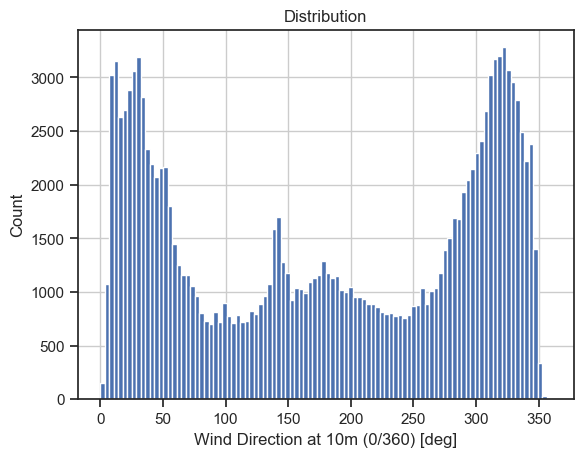

In [120]:
df['Wind Direction at 10m (0/360) [deg]'].hist(bins=100)
plt.xlabel('Wind Direction at 10m (0/360) [deg]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

Distributions which small range values:
* 'Particle (Large) at 20m [1/m^3]'
* 'Particle (Large) at 10m [1/m^3]'
* 'Particle (Small) at 20m [1/m^3]'
* 'Particle (Small) at 10m [1/m^3]'
* 'Particle (Large) Instantanous at 20m [1/m^3]'
* 'Particle (Large) instantanous at 10m [1/m^3]'
* 'Particle (Small) instantanous at 20m [1/m^3]'
* 'Particle (Small) instantanous at 10m [1/m^3]'

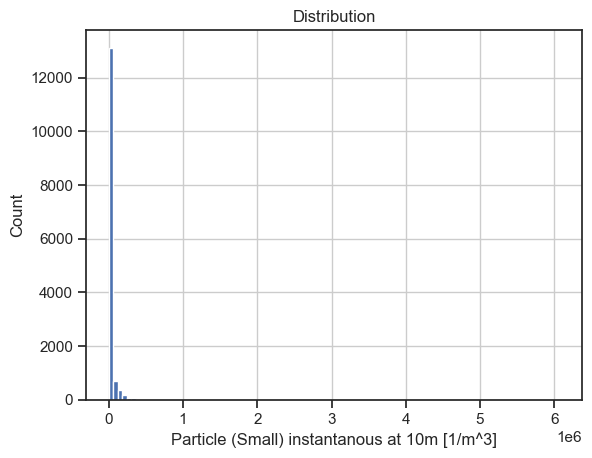

In [124]:
df['Particle (Small) instantanous at 10m [1/m^3]'].hist(bins=100) ## maybe for all of these features (refering to particle...) would be better do a zoom in
plt.xlabel('Particle (Small) instantanous at 10m [1/m^3]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

We have almost the same for wind speed W...

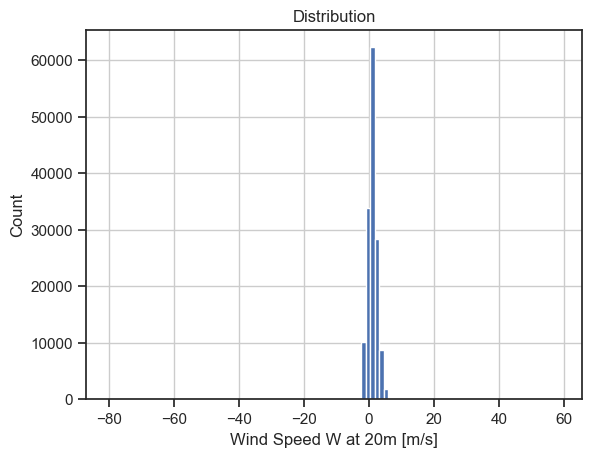

In [125]:
df['Wind Speed W at 20m [m/s]'].hist(bins=100) 
plt.xlabel('Wind Speed W at 20m [m/s]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

against to:

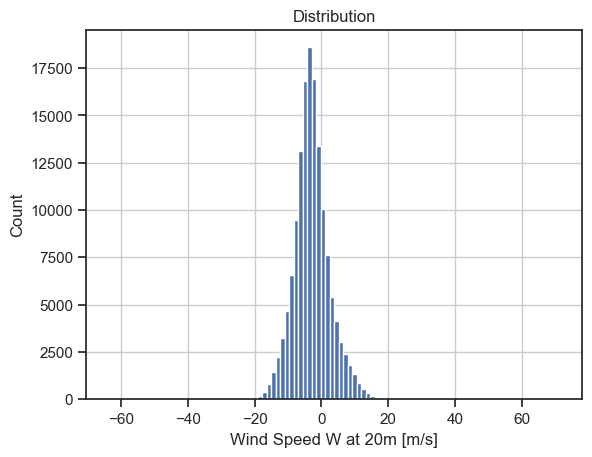

In [126]:
df['Wind Speed U at 20m [m/s]'].hist(bins=100) 
plt.xlabel('Wind Speed W at 20m [m/s]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

Rest of them follow a distribution normal-like or log-normal, for example:

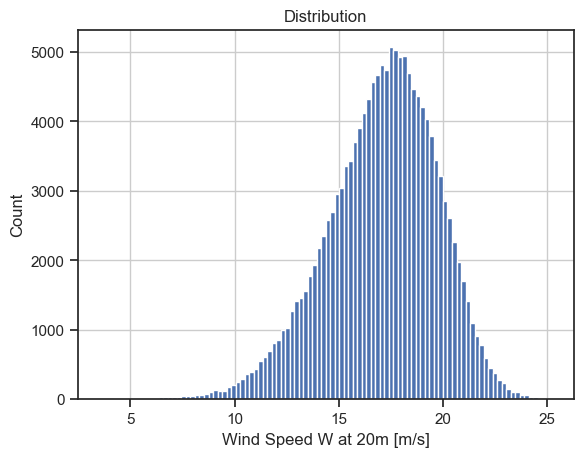

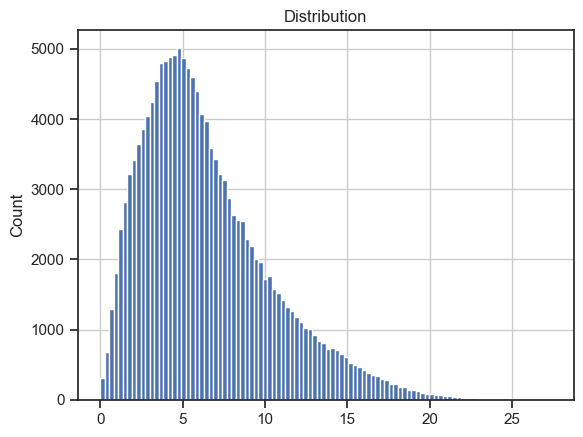

In [148]:
df['Air Temperature at ground [C]'].hist(bins=100) 
plt.xlabel('Wind Speed W at 20m [m/s]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()
df['Wind Speed at 10m [m/s]'].hist(bins=100) 
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

so here the idea would be apply a log transformation in the first instance

## Histogram by year


In [145]:
def plot_density_by_year(df,variable,folder = "../plots/histograms_per_year/",save = True ):
    grouped_data = df.groupby(df.index.year)
    fig, axes = plt.subplots(nrows=len(grouped_data), figsize=(5, 2.5 * len(grouped_data)))
    for i, (year, group) in enumerate(grouped_data):
        sns.kdeplot(data=group[variable], ax=axes[i], fill=True, label=f'Year {year}')
        axes[i].set_title(f'Year {year}')
        # group[variable].plot(kind='hist', ax=axes[i], bins=10, title=f'Histogram for Year {year}')
        axes[i].set_xlim(df[variable].min(), df[variable].max())
        median_value = group[variable].median()
        avg_value = group[variable].mean()
        axes[i].axvline(x=median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
        axes[i].axvline(x=avg_value, color='g', linestyle='--', label=f'Avg: {avg_value:.2f}')
        axes[i].legend(loc='upper right', bbox_to_anchor=(1.3, 1))
        
    axes[-1].set_xlabel(variable)
    axes[-1].set_ylabel('Density')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(folder + f"density_by_year_for_{variable.replace('/','')}.png",dpi = 100)

In [ ]:
df['year'] = df.index.year
# histogram per variables 
def create_histogram(variable,year):
    return df[df.year==year].hvplot.hist(y=variable, bins=150, title=f'Histogram of {variable}')

variables_list = numeric_col
year_list = list(df.year.unique())
histogram_dmap = hv.DynamicMap(create_histogram, kdims=['variable','year']).redim.values(variable=variables_list,year = year_list)
layout = histogram_dmap.opts(framewise=True)
layout

Here we have some distributions which varies a bit per year:

* Air Temperature at ground [C]
* Air Temperature below VLT [C]
* Air Temperature instantaneous below VLT [C]
* Air Temperature instantanous at 2m [C]
* Air Temperature instantanous at 30m [C]
* Air Temperature instantanous at ground [C]

For example:

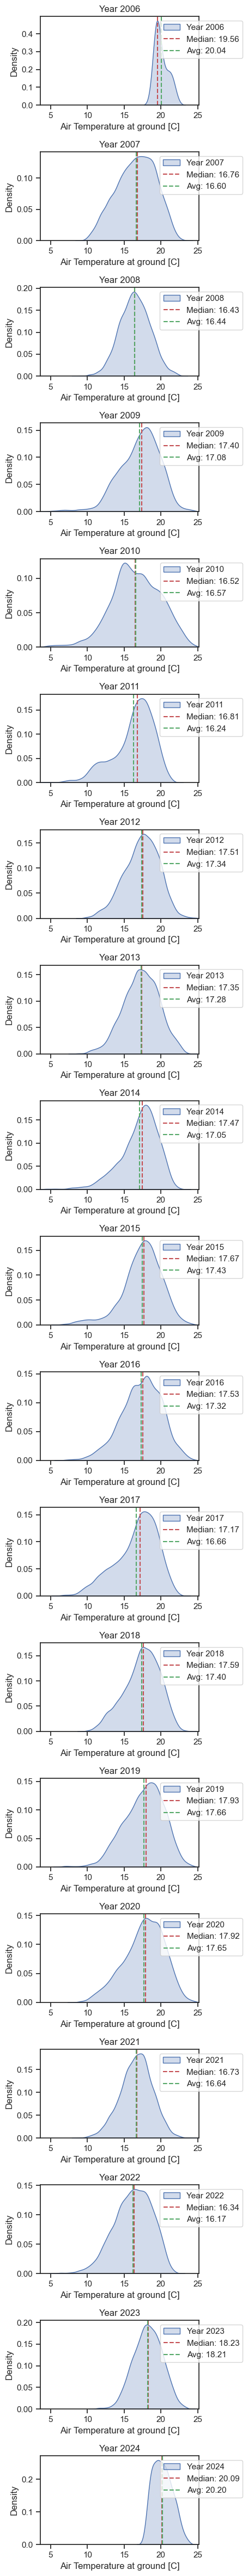

In [146]:
plot_density_by_year(df,'Air Temperature at ground [C]',save = False )

In the other hand we have some distribution which varies a lot per year, like:
* 'Dew Temperature at 30m [C]'
* 'Dew Temperature at 2m [C]'
* 'Dew Temperature below VLT [C]'
* 'Dew Temperature istantaneous at 30m [C]'
* 'Dew Temperature instantanous at 2m [C]'
* 'Dew Temperature instantanous below VLT [C]'
* 'Humidity instantanous below VLT [%]'

* 'Wind Direction at 30m (0/360) [deg]'
* 'Wind Direction at 30m (180/-180) [deg]'
* 'Wind Direction at 10m (0/360) [deg]'
* 'Wind Direction at 10m (180/-180) [deg]'

for example Dew Temperature at 30m [C]

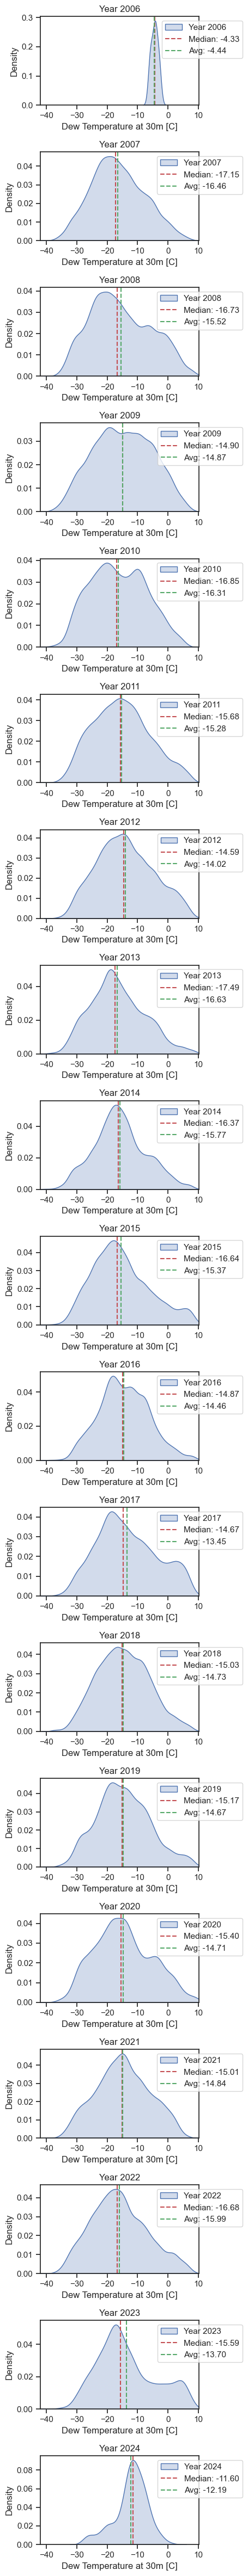

In [147]:
plot_density_by_year(df,'Dew Temperature at 30m [C]',save = False )

In [153]:
df.groupby('year').describe()['Wind Direction at 30m (0/360) [deg]']

count        mean         std         min         25%         50%  \
year                                                                       
2006    11.0  258.659091   36.407217  188.000000  242.908333  279.233333   
2007  8611.0  176.064911  124.069887    0.000000   42.650000  173.433333   
2008  8599.0  180.380284  121.674758    1.416667   49.200000  183.576271   
2009  7824.0  183.119539  113.087391    0.000000   64.763679  181.333333   
2010  8073.0  173.966063  123.948638    0.000000   42.566667  168.116667   
2011  8660.0  176.971099  119.910473    0.000000   48.229167  174.908333   
2012  8689.0  178.618871  116.103043    1.433333   56.666667  175.250000   
2013  8441.0  180.847227  117.064418    0.733333   56.303571  179.600000   
2014  8664.0  173.479356  120.989309    0.000000   45.769737  167.410707   
2015  8339.0  189.345554  115.749075    0.000000   64.968501  195.928571   
2016  8700.0  175.175068  120.213490    0.000000   46.825000  171.116667   
2017  8693.0  171.722185  120.748040    0.000000   43.750000  166.033333   
2018  8730.0  185.539746  112.360363    1.850000   68.766667  188.016667   
2019  8756.0  177.106489  117.634031    0.000000   53.146398  172.766667   
2020  8777.0  174.541456  115.672084    0.183333   53.266667  170.583333   
2021  8739.0  167.480855  124.291136    0.650000   39.091667  160.266667   
2022  8743.0  168.133915  122.329966    1.683333   42.616667  158.566667   
2023  8760.0  183.833053  114.429563    1.200000   65.941667  181.650000   
2024   387.0  190.446792   87.725216    4.983333  147.091667  180.150000   

             75%         max  
year                          
2006  283.683333  294.050000  
2007  308.554661  356.428571  
2008  304.389655  359.000000  
2009  296.666667  354.948276  
2010  305.456140  359.500000  
2011  302.616667  357.200000  
2012  298.233333  358.000000  
2013  300.650000  356.666667  
2014  302.116405  356.543860  
2015  303.256579  355.171429  
2016  302.408333  357.133333  
2017  296.850000  355.216667  
2018  295.625000  356.883333  
2019  296.970833  356.566667  
2020  293.783333  356.283333  
2021  302.241667  356.450000  
2022  301.208333  356.783333  
2023  298.695833  355.016667  
2024  265.958333  348.733333

## Scatterplot

In [180]:
def plot_and_scatter(df, year1, year2, variable1, variable2, folder="../plots/scatterplot/", save=True):
    plt.clf()

    df_year1 = df[df.index.year == year1]
    df_year2 = df[df.index.year == year2]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.scatterplot(x=df_year1[variable1], y=df_year1[variable2], marker='o', color="#4CB391", ax=axes[0],s=3)
    axes[0].set_xlabel(f'{variable1}')
    axes[0].set_ylabel(f'{variable2}')
    axes[0].set_title(f' Year {year1}')

    sns.scatterplot(x=df_year2[variable1], y=df_year2[variable2], marker='o', color="#4CB391", ax=axes[1],s=3)
    axes[1].set_xlabel(f'{variable1}')
    axes[1].set_ylabel(f'{variable2}')
    axes[1].set_title(f' Year {year2}')

    plt.tight_layout()

    if save:
        plt.savefig(folder + f"Scatterplot_{variable1.replace('/','')}_&&&_{variable2.replace('/','')}_Years_{year1}_{year2}.png", dpi=100)

    plt.show()


Here I selected some pair I found interesting, according to a specfic year.

<Figure size 640x480 with 0 Axes>

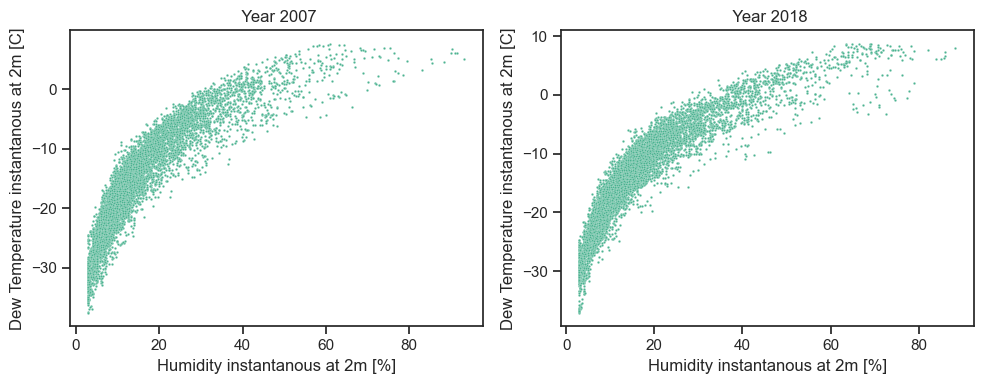

<Figure size 640x480 with 0 Axes>

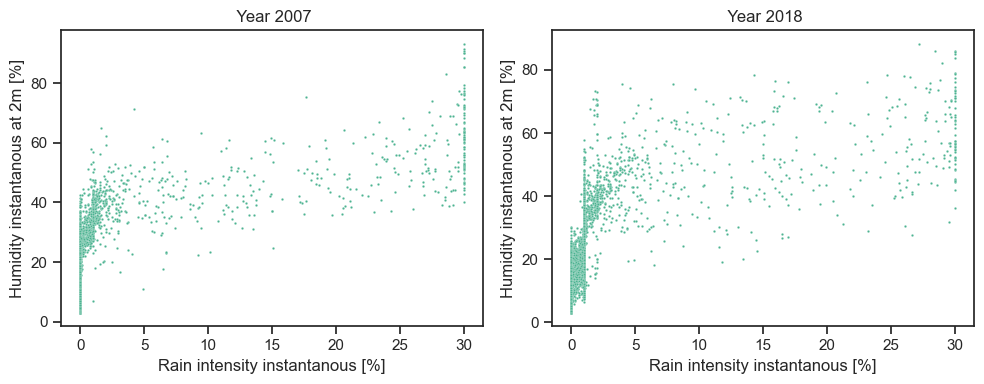

<Figure size 640x480 with 0 Axes>

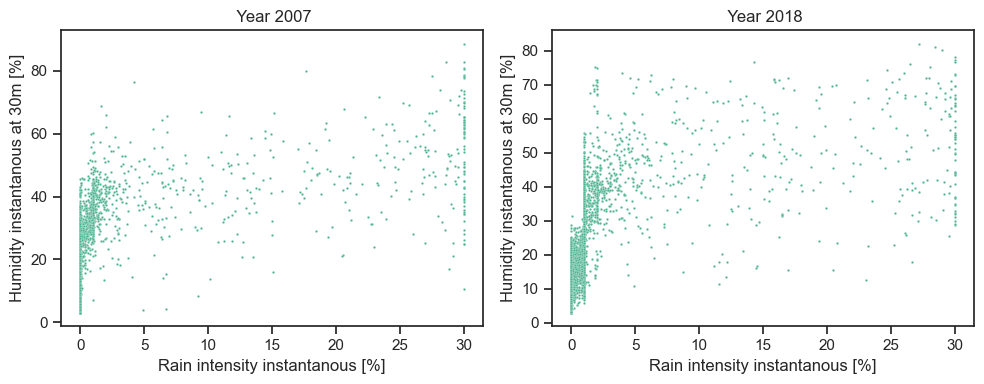

<Figure size 640x480 with 0 Axes>

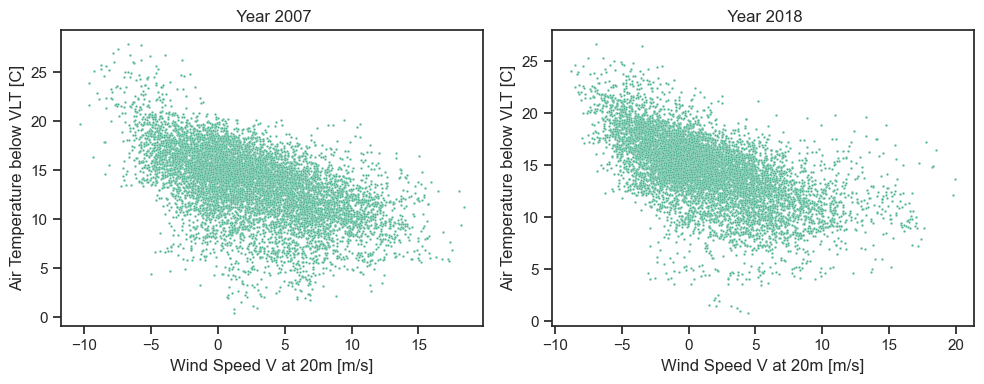

<Figure size 640x480 with 0 Axes>

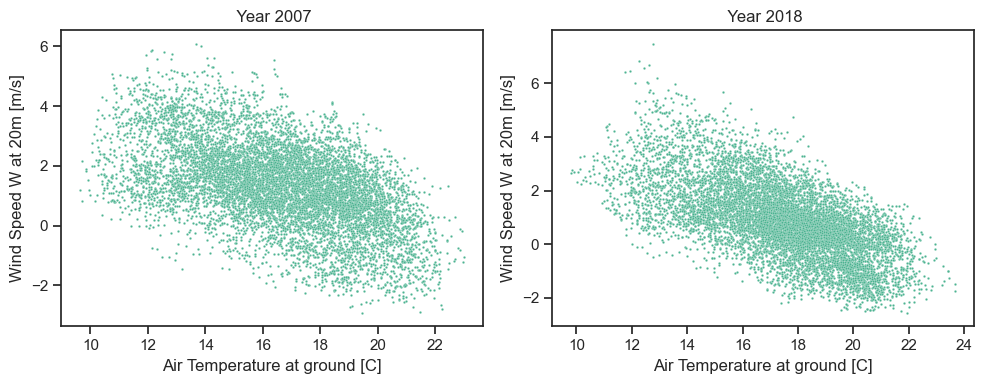

<Figure size 640x480 with 0 Axes>

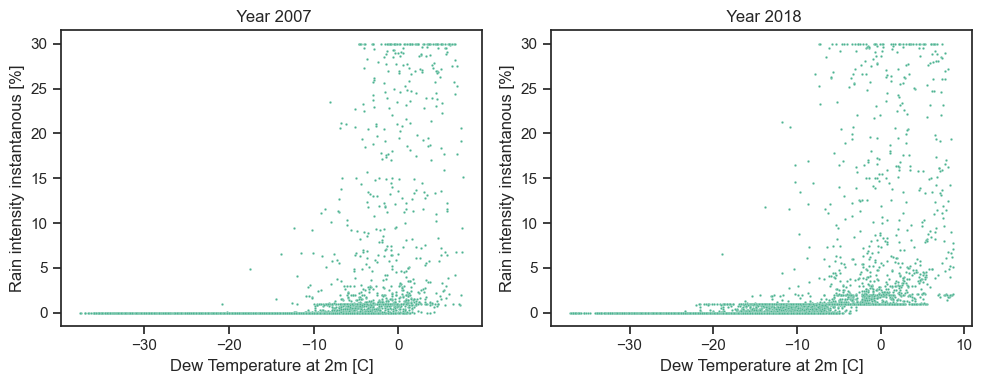

In [181]:

pairs = [
    # most correlated
    ('Humidity instantanous at 2m [%]',	'Dew Temperature instantanous at 2m [C]'),
    ('Rain intensity instantanous [%]',	'Humidity instantanous at 2m [%]'),
    ('Rain intensity instantanous [%]',	'Humidity instantanous at 30m [%]'),

    # less correlated
    ('Wind Speed V at 20m [m/s]',	'Air Temperature below VLT [C]'),
    # other
    ('Air Temperature at ground [C]' , 'Wind Speed W at 20m [m/s]'),
    ('Dew Temperature at 2m [C]', 'Rain intensity instantanous [%]'), # -10,1 chequear punto
]

import random

year1= random.randint(2006, 2024)
year2= year1
while year2==year1: 
    year2 = random.randint(2006, 2024)

for pair in pairs:
    plot_and_scatter(df,year1,year2,pair[0],pair[1],save = False)

Here for 2018, we see that for values >~30% of humidity reain intensity starts to increase, same for Dew temperature, there should be a inflexion point where dew temperature and humidity increases according to the rain, is a logic assumption based in basics. And that shows the first plot.

We see this in the next historical plot:

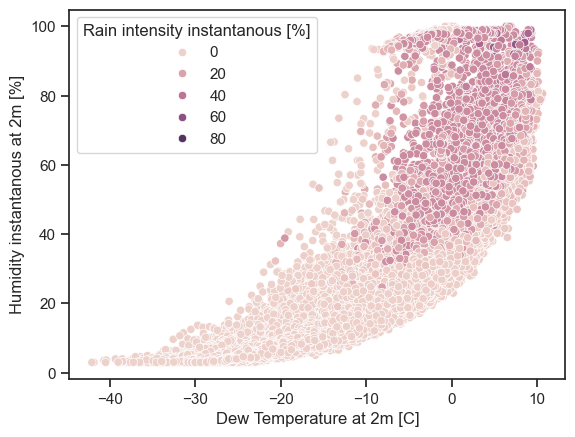

In [184]:
sns.scatterplot(x=df['Dew Temperature at 2m [C]'],y = df['Humidity instantanous at 2m [%]'], hue= df['Rain intensity instantanous [%]'])
plt.show()

In [ ]:
def create_scatter(year,variable1, variable2):
    plot = hv.Scatter((df[df.year==year][variable1], df[df.year==year][variable2]))
    plot.opts(size = 1,title = "",xlabel = variable1,ylabel=variable2)
    return plot

variables_list = numeric_col
scatter_dmap = hv.DynamicMap(create_scatter, kdims=['year','variable1', 'variable2']).redim.values(year=list(df.year.unique()),
                                                                                                   variable1=variables_list, 
                                                                                                   variable2=variables_list)
layout = scatter_dmap.opts(framewise=True,width=600, height=400)
layout

## time series subplots

In [ ]:
def create_scatter(year, variable1):
    plot = hv.Scatter((df[df.year==year].index, df[df.year==year][variable1]))
    plot.opts(size = 2,title = "",xlabel = "time",ylabel=variable1)
    return plot

variables_list = numeric_col
scatter_dmap = hv.DynamicMap(create_scatter, kdims=['variable1', 'year']).redim.values(variable1=variables_list, year=list(df.year.unique()))
layout = scatter_dmap.opts(framewise=True,width=800, height=400)
layout

In [234]:
def plot_roll_mean(df,moving_average,year,variable,variable_list_air):
        
        fig, ax = plt.subplots(figsize=(25, 5))
        df[df.year == year][variable].plot(style=".", color="0.5", ax=ax,label=variable)
        moving_average[moving_average.year == year][variable_list_air[0]].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'blue', label='Moving mean of '+variable_list_air[0])
        moving_average[moving_average.year == year][variable_list_air[1]].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'red', label='Moving mean of '+variable_list_air[1])
        moving_average[moving_average.year == year][variable_list_air[2]].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'green', label='Moving mean of '+variable_list_air[2])
        # df[variable].plot(style=".", color="0.5", ax=ax,label=variable)
        # moving_average['Air Temperature at 2m [C]'].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'red', label='Moving mean')
        plt.xlabel('Timestamp')
        plt.ylabel(variable)
        ax.legend()
        plt.show()

In [225]:
moving_average = df.rolling(
    window=400,       
    center=True,      
    min_periods=200,  # minimo puntos requeridos, sino retorna nan
).mean()              

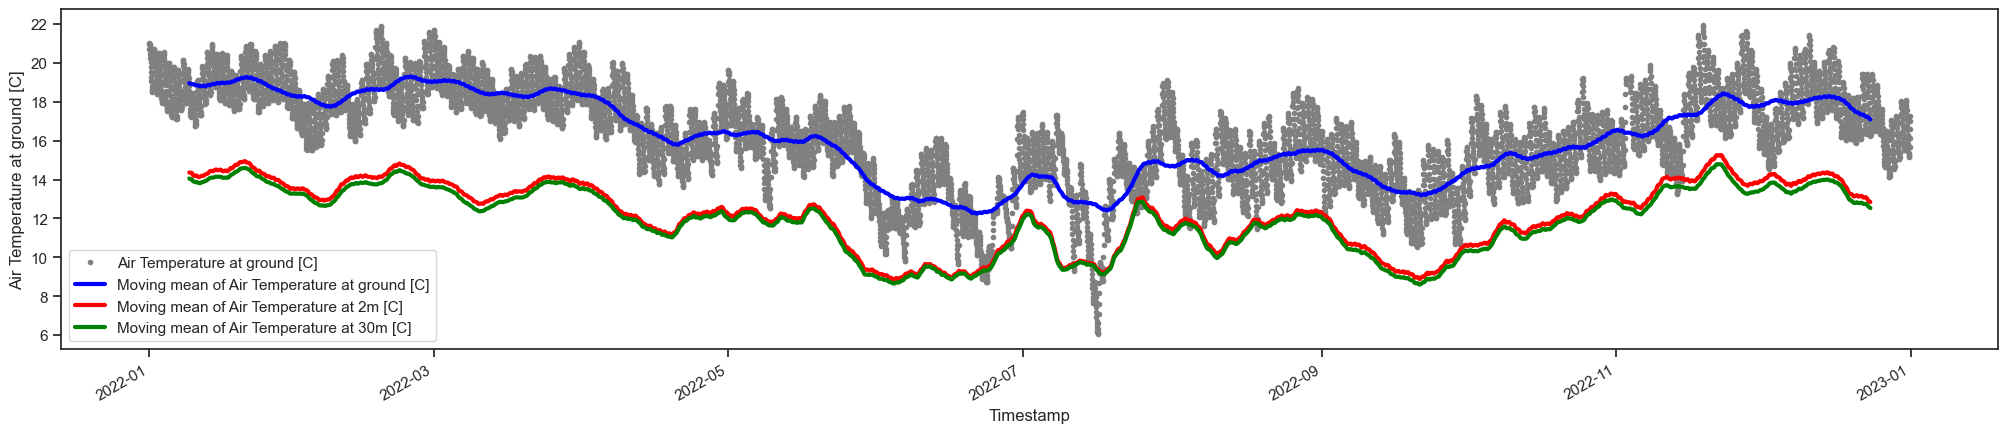

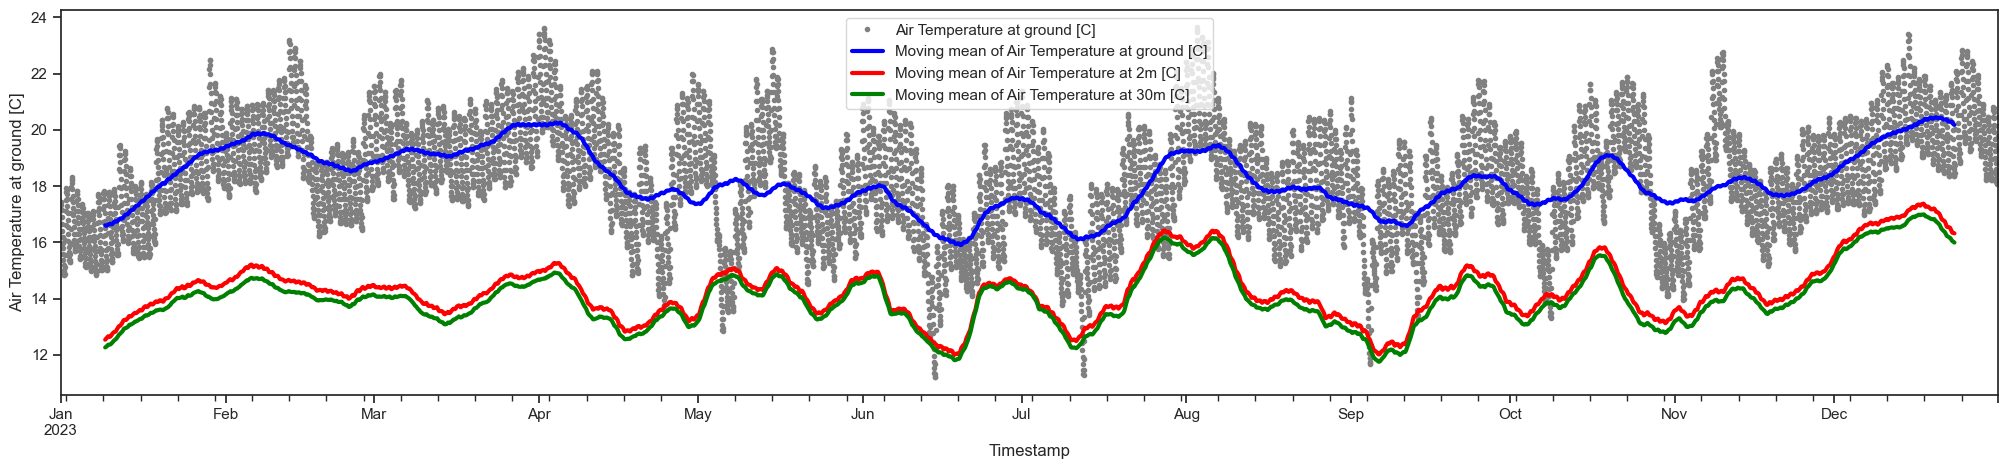

In [238]:
years = [2022,2023]
variable = 'Air Temperature at ground [C]'

variable_list_air = ['Air Temperature at ground [C]','Air Temperature at 2m [C]','Air Temperature at 30m [C]']

for year in years:
    plot_roll_mean(df,moving_average,year,variable,variable_list_air)

Very nice these plots. Shows that the temperature at ground is warmer, and if we goes higher, the air temperature is cooler. As the physics says

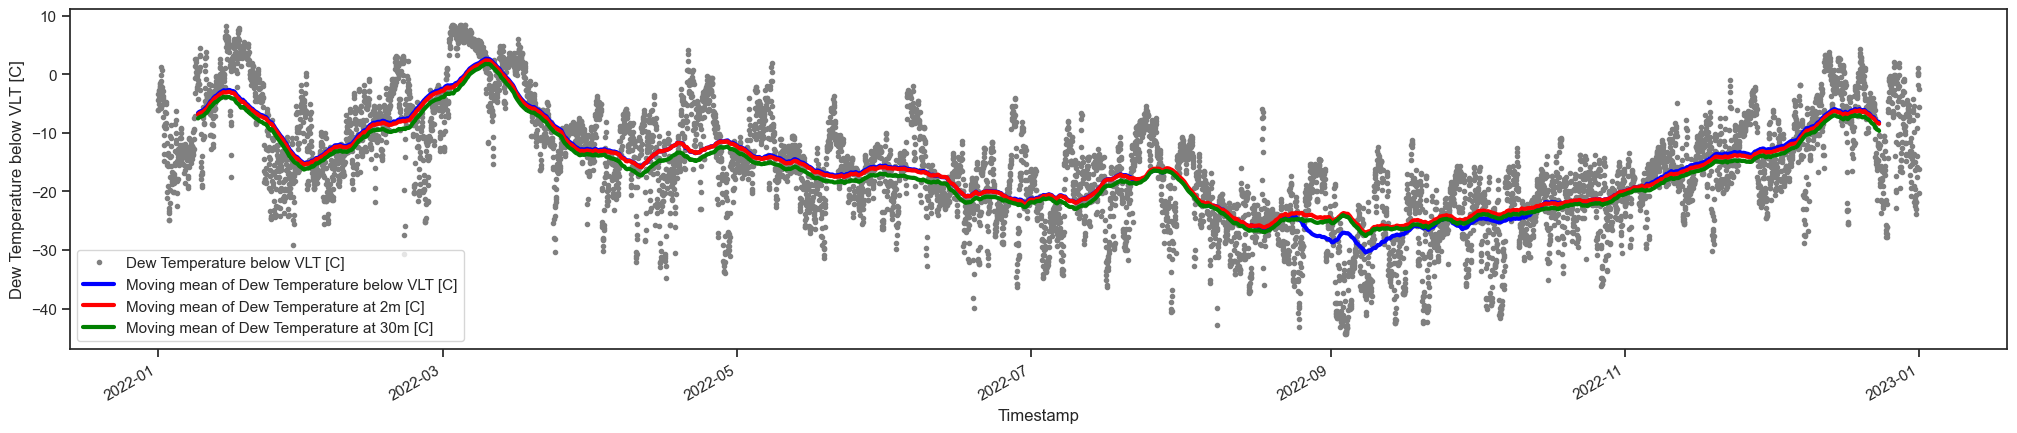

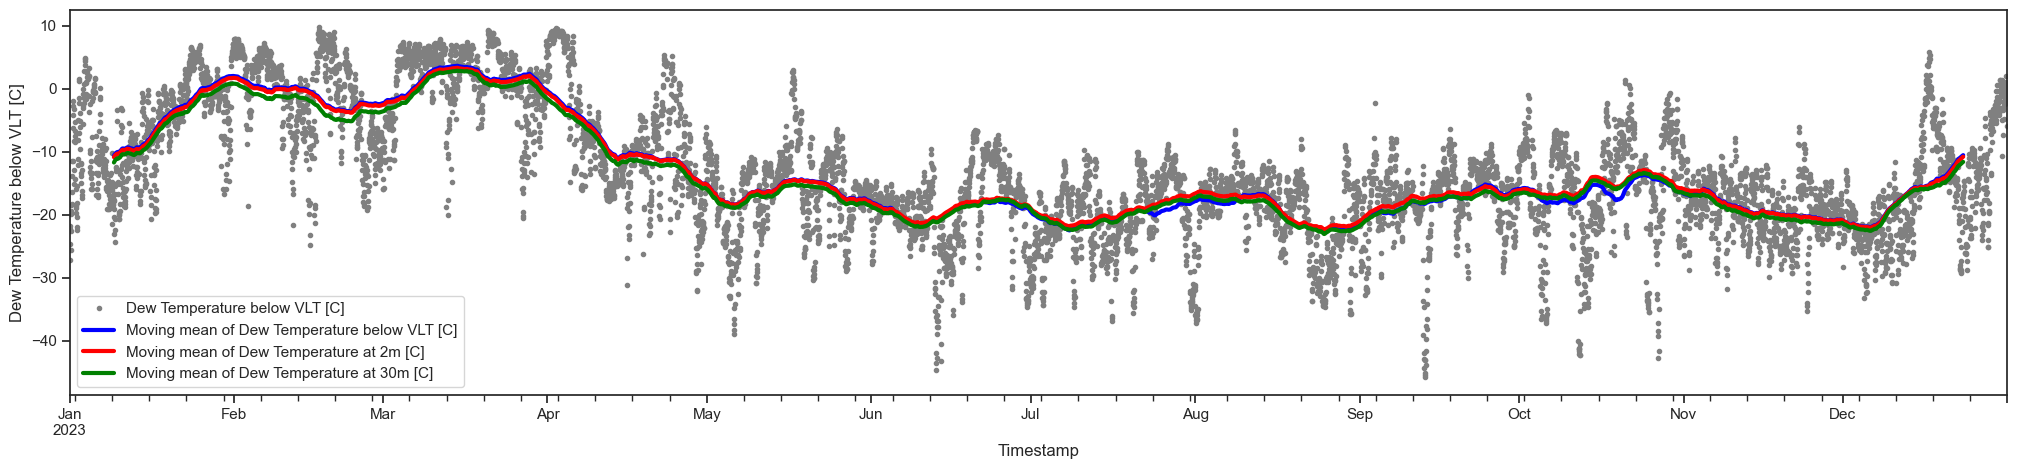

In [241]:
variable = 'Dew Temperature below VLT [C]'

variable_list = ['Dew Temperature below VLT [C]','Dew Temperature at 2m [C]','Dew Temperature at 30m [C]']

for year in years:
    plot_roll_mean(df,moving_average,year,variable,variable_list)

Here Dew temperature has almost the same tendence acording to levels, at the level of VLT has some differences

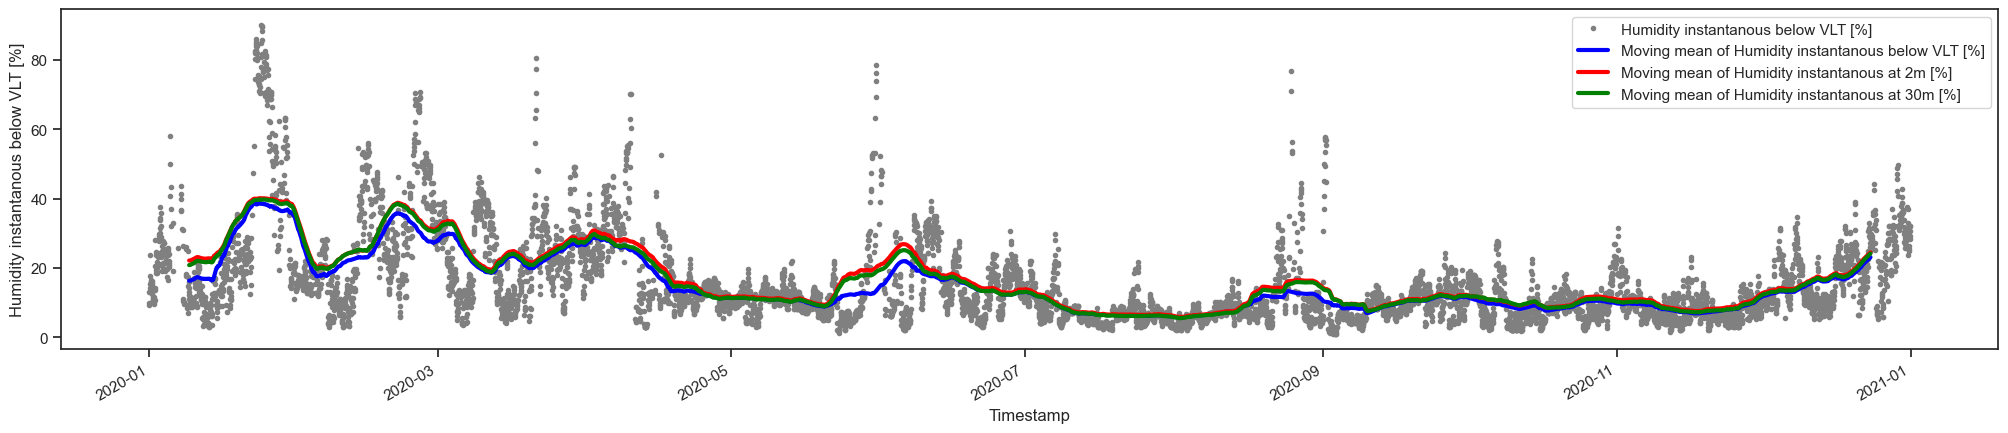

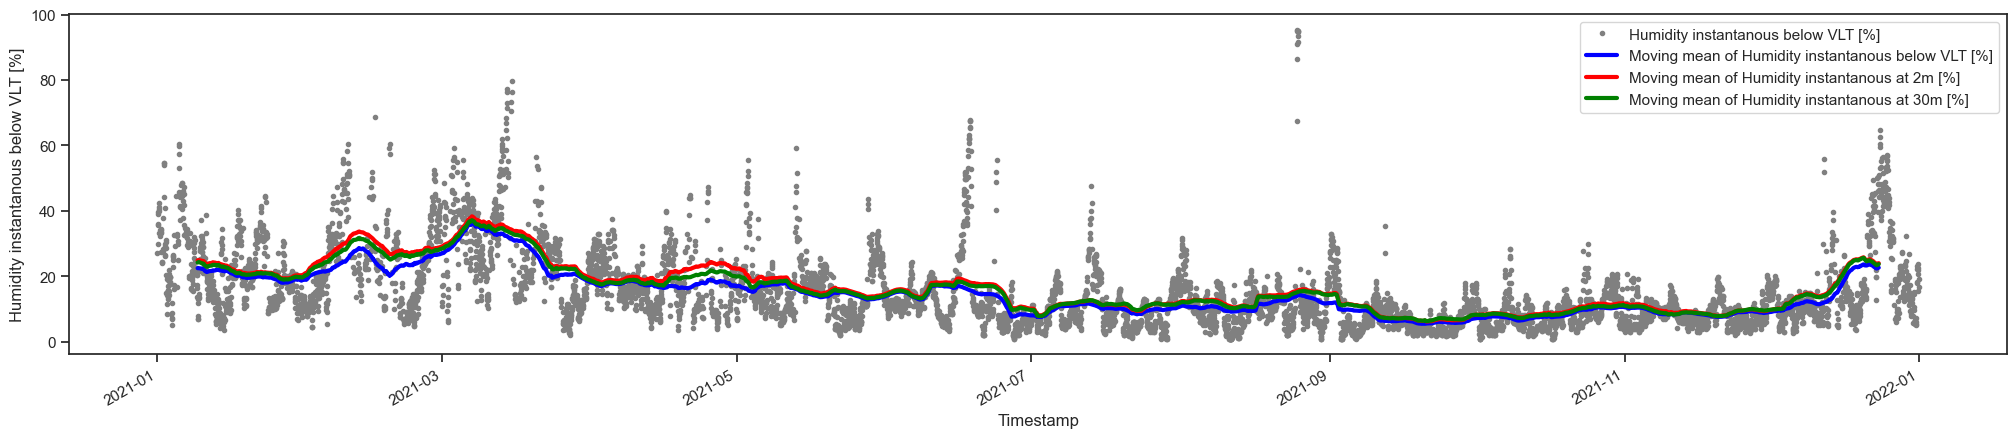

In [243]:
years= [2020,2021]
variable = 'Humidity instantanous below VLT [%]'

variable_list = [ 'Humidity instantanous below VLT [%]',
 'Humidity instantanous at 2m [%]',
 'Humidity instantanous at 30m [%]']

for year in years:
    plot_roll_mean(df,moving_average,year,variable,variable_list)

* Here the plots shows that at highest levels we find a bit more humidity 

### Next steps
* see variables periodicity by season, night/day
* what we find if we apply clusterization
* do the same but with different aggregation, here we did it with 1 hour, doing it with 15 min would be more accurate
* apply directly transformation and see its behaviors